#  **Практическое занятие №5. Домашняя работа.**

### Импорт библиотек

In [56]:
import torch
from torch import nn
from torch.nn import functional as F

# У вас может не быть этой библиотеки!
from torchsummary import summary

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

seed = 777
batch_size = 128
learning_rate = 0.0012

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda:0


### Згрузка и обработка датасета MNIST

In [6]:
from torchvision import datasets
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

# Загрузка
mnist_dataset = datasets.MNIST(root='mnist', download=True)

# Подготовка
x, y = mnist_dataset.data.to(device), mnist_dataset.targets.to(device)

y = F.one_hot(y, num_classes=10).to(torch.float)
x = x / 255 * 2 - 1

# x.to(device)
# y.to(device)

# Разделение
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1 / 6), random_state=seed)

# Создание
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Изучение особенностей датасета

In [3]:
print(mnist_dataset)
print(x_train.shape, x.dtype)
print(y, type(y))

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist
    Split: Train
torch.Size([50000, 28, 28]) torch.float32
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]], device='cuda:0') <class 'torch.Tensor'>


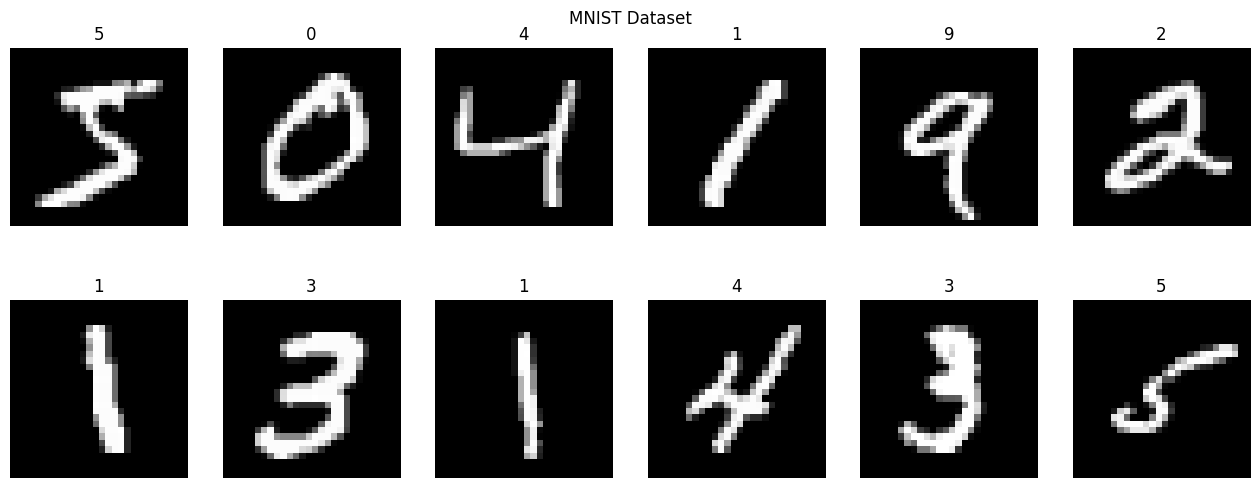

In [7]:
plt.figure(figsize=(16, 6))
plt.title("MNIST Dataset")
plt.axis('off')

for i in range(12):
    x_, y_ = mnist_dataset[i]
    plt.subplot(2, 6, i + 1)
    plt.title(f'{y_}')
    plt.axis('off')
    plt.imshow(x_, cmap='gray')

plt.show()

(60000, 10)


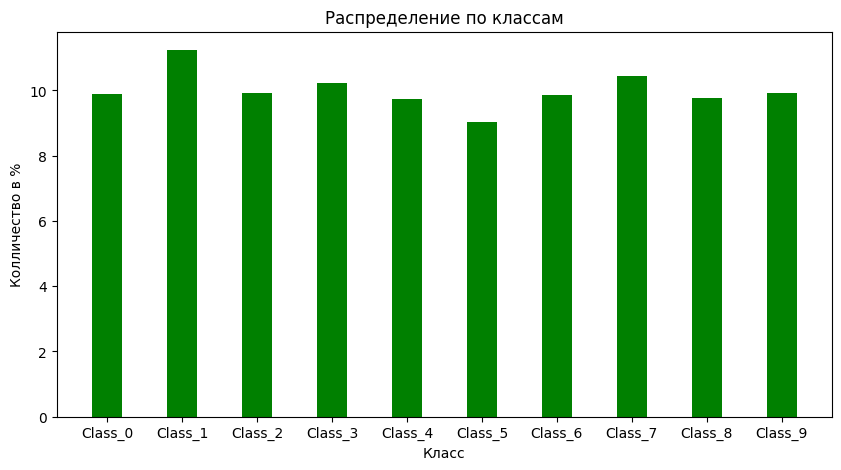

In [8]:
stat = y.detach().cpu().numpy()
print(stat.shape)
stat = np.mean(stat, axis=0)
# print(stat)

fig = plt.figure(figsize=(10, 5))
plt.bar([f"Class_{i}" for i in range(10)], stat * 100, color='green', width=0.4)
plt.xlabel("Класс")
plt.ylabel("Колличество в %")
plt.title("Распределение по классам")
plt.show()

### Архитектуры моделей

In [163]:
# 1
class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "Model_1 Small FNN"
        
        self.fc1 = nn.Linear(28 * 28, 96)
        self.fc2 = nn.Linear(96, 32)
        self.fc3 = nn.Linear(32, 10)
        
        self.bn1 = nn.BatchNorm1d(96)
        self.bn2 = nn.BatchNorm1d(32)
        nn.Flatten
        
        self.dropout = nn.Dropout(p=0.22)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        logits = self.fc3(x)
        return logits


# 2
class Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "Model_2 Big FNN"
        
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.22)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        logits = self.fc5(x)
        return logits
    

# 3
class Model_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "Model_3 Small CNN"
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(3, 3), stride=1, padding=1)
        
        self.fc = nn.Linear(432, 10)
        # self.fc2 = nn.Linear(432, 10)

        self.dropout = nn.Dropout(p=0.21)
        self.pool_2x2 = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        x = x[:, None, :, :]
        x = self.pool_2x2(F.relu(self.conv1(x)))
        x = self.pool_2x2(F.relu(self.conv2(x)))
    
        x = self.dropout(torch.flatten(self.pool_2x2(x), start_dim=1))
        logits = self.fc(x)
        return logits

    
# 4
class Model_4(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "Model_4 Big CNN"
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(3, 3), stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=(2, 2), stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=(2, 2), stride=1, padding=1)
        
        self.fc1 = nn.Linear(384, 64)
        self.fc2 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.23)
        self.pool_2x2 = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        x = x[:, None, :, :]
        x = self.pool_2x2(F.relu(self.conv1(x)))
        x = self.pool_2x2(F.relu(self.conv2(x)))
        x = self.pool_2x2(F.relu(self.conv3(x)))
        x = self.pool_2x2(F.relu(self.conv4(x)))
    
        x = self.dropout(torch.flatten(x, start_dim=1))
        x = self.dropout(F.relu(self.fc1(x)))
        logits = self.fc2(x)
        return logits

In [147]:
def get_softmax(current_model, input_tensor, is_round=False):
    logits = current_model(input_tensor)
    sm = F.softmax(logits, dim=-1).detach().cpu().numpy()
    if is_round:
        return np.round(sm, 3)
    return sm


def train(model, epochs: int, metrics=True):
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in train_loader:
            # Prevent accumulation of gradients
            optimizer.zero_grad()
            # Make predictions
            log_pred = model(images)
            loss = loss_function(log_pred, labels)
            #backprop
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            
    
    
        # Turn off gradients for validation
        with torch.no_grad():
            model.eval()
            test_loss = total = total_correct = 0
            
            for images, labels in test_loader:
                # Forward propagation
                outputs = model(images)
                test_loss += loss_function(outputs, labels)
                
                # Total number of labels
                total += len(labels)
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                # Total correct predictions
                correct = (predicted == torch.max(labels, 1)[1]).sum()
                total_correct += correct.detach().cpu().numpy()
            
            accuracy = total_correct / total
    
        model.train(True)
        
        if metrics:
            train_losses.append(running_loss / len(train_loader))
            test_losses.append((test_loss.detach().cpu().numpy() / len(test_loader)))
            print(f"Epoch: {epoch + 1}/{EPOCHS} \t",
                  f"Training Loss: {train_losses[-1]:.3f}\t",
                  f"Test Loss: {test_losses[-1]:.3f}\t",
                  f"Test Accuracy: {accuracy:.3f}")
    
    model.eval()
    model.train(False)
    return train_losses, test_losses

### Обучение и сравнение моделей

In [170]:
# Instantiate our model
model = Model_4()
model.to(device)

# Summary
summary(model, input_size=(28, 28), batch_size=batch_size)

# Define our loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimier
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 32, 28, 28]             320
         MaxPool2d-2          [128, 32, 14, 14]               0
            Conv2d-3          [128, 48, 14, 14]          13,872
         MaxPool2d-4            [128, 48, 7, 7]               0
            Conv2d-5            [128, 64, 8, 8]          12,352
         MaxPool2d-6            [128, 64, 4, 4]               0
            Conv2d-7            [128, 96, 5, 5]          24,672
         MaxPool2d-8            [128, 96, 2, 2]               0
           Dropout-9                 [128, 384]               0
           Linear-10                  [128, 64]          24,640
          Dropout-11                  [128, 64]               0
           Linear-12                  [128, 10]             650
Total params: 76,506
Trainable params: 76,506
Non-trainable params: 0
---------------------------------

In [171]:
EPOCHS = 20

train_losses, test_losses = train(model, EPOCHS)

Epoch: 1/20 	 Training Loss: 0.386	 Test Loss: 0.085	 Test Accuracy: 0.974
Epoch: 2/20 	 Training Loss: 0.093	 Test Loss: 0.073	 Test Accuracy: 0.979
Epoch: 3/20 	 Training Loss: 0.070	 Test Loss: 0.049	 Test Accuracy: 0.987
Epoch: 4/20 	 Training Loss: 0.054	 Test Loss: 0.049	 Test Accuracy: 0.986
Epoch: 5/20 	 Training Loss: 0.049	 Test Loss: 0.045	 Test Accuracy: 0.987
Epoch: 6/20 	 Training Loss: 0.039	 Test Loss: 0.039	 Test Accuracy: 0.989
Epoch: 7/20 	 Training Loss: 0.035	 Test Loss: 0.041	 Test Accuracy: 0.989
Epoch: 8/20 	 Training Loss: 0.031	 Test Loss: 0.043	 Test Accuracy: 0.989
Epoch: 9/20 	 Training Loss: 0.029	 Test Loss: 0.036	 Test Accuracy: 0.990
Epoch: 10/20 	 Training Loss: 0.027	 Test Loss: 0.034	 Test Accuracy: 0.991
Epoch: 11/20 	 Training Loss: 0.025	 Test Loss: 0.037	 Test Accuracy: 0.991
Epoch: 12/20 	 Training Loss: 0.026	 Test Loss: 0.037	 Test Accuracy: 0.991
Epoch: 13/20 	 Training Loss: 0.022	 Test Loss: 0.034	 Test Accuracy: 0.991
Epoch: 14/20 	 Traini

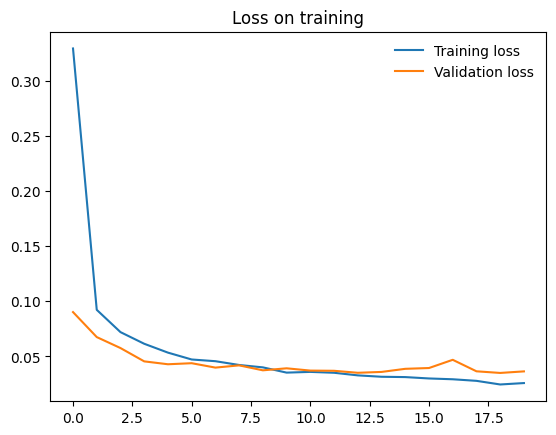

In [167]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.title("Loss on training")
plt.show()

In [172]:
# print(get_softmax(model, x_train[:3]))
# print(get_softmax(model, x_train))
y_pred = get_softmax(model, x_test)
y_pred_onehot = F.one_hot(torch.argmax(torch.Tensor(y_pred), dim=-1))
y_test_np = y_test.detach().cpu().numpy()

average_metric = 'macro'  # 'macro', 'micro', 'weighted'

print(f"Accuracy test:  {sklearn.metrics.accuracy_score(y_test_np, y_pred_onehot) :.4f}")
print(f"Precision test: {sklearn.metrics.precision_score(y_test_np, y_pred_onehot, average=average_metric) :.4f}")
print(f"Recall test:    {sklearn.metrics.recall_score(y_test_np, y_pred_onehot, average=average_metric) :.4f}")
print(f"F1 test:        {sklearn.metrics.f1_score(y_test_np, y_pred_onehot, average=average_metric) :.4f}")

Accuracy test:  0.9909
Precision test: 0.9908
Recall test:    0.9909
F1 test:        0.9908


### Сравнение разных моделей
Я заранее посчитал и внес в таблицу значения метрик разных вариаций моделей

In [173]:
from IPython.display import display
import pandas as pd
 
# creating a DataFrame
dict = {'Model': ['Small FNN', 'Big FNN', 'Small CNN', 'Big CNN'],
        'Accuracy':  [0.9769, 0.9784, 0.9903, 0.9909],
        'Precision': [0.9767, 0.9784, 0.9902, 0.9908],
        'Recall':    [0.9769, 0.9783, 0.9904, 0.9909],
        'F1 score':  [0.9768, 0.9783, 0.9903, 0.9908],}
df = pd.DataFrame(dict)
 
# displaying the DataFrame
display(df)

,Model,Accuracy,Precision,Recall,F1 score
0,Small FNN,0.9769,0.9767,0.9769,0.9768
1,Big FNN,0.9784,0.9784,0.9783,0.9783
2,Small CNN,0.9903,0.9902,0.9904,0.9903
3,Big CNN,0.9909,0.9908,0.9909,0.9908


### Итоги работы

В ходе работы я обработал и подготовил датасет MNIST, протестировали разные модели (полносвязные и сверточные) и сравнил их эффективность. Из сравнения ясно видно, что сверточные сети показывают себя лучше (при этом имея меньше весов). Большие модели в обоих случаях имели чуть большую точность, хотя разница и невелика. По итогу получилось добиться точности распознавания более 99% при 10 классах.